In order to run part 1 we need the following libraries:
* open3d
* numpy
In order to run part 2 we need the following libraries:
* vedo
* trimesh
* pymesh
* pyngrok


In [1]:
import pymeshlab
import os
import numpy as np
import pandas as pd
import open3d as o3d
import matplotlib.pyplot as plt
import seaborn as sns
import vedo
from vtkmodules.vtkFiltersGeneral import vtkDensifyPolyData
from vtkmodules.vtkCommonDataModel import vtkPolyData
from vtkmodules.vtkCommonExecutionModel import vtkAlgorithm
import math
from collections import defaultdict,deque
import itertools
import random
import ast
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Part 1

In [2]:

mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"


def visualizer(mesh_path):
    # Load the mesh with open3d
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    mesh.compute_vertex_normals()

    # Visualize the mesh
    vis_option = "wireframe_on_shaded"
    if vis_option == "smoothshade":
        o3d.visualization.draw_geometries([mesh], width=1280, height=720)
    elif vis_option == "wireframe_on_shaded":
        # Wireframe atop solid mesh
        # Create a visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window()

        # Add solid mesh to visualizer
        vis.add_geometry(mesh)

        # Slightly displace the wireframe mesh to avoid z-fighting (mimicking OpenGL offset)
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        wireframe.paint_uniform_color([0, 0, 0])  # Set wireframe color

        # Render solid mesh first, then the wireframe
        vis.add_geometry(wireframe)

        # Get render options and enable hidden surface removal for the wireframe
        opt = vis.get_render_option()
        opt.mesh_show_back_face = True  # Show back faces to ensure wireframe shows fully

        vis.run()
        vis.destroy_window()
    elif vis_option == "wireframe":
        # We first need to obtain a lineset of the wireframe if we don't want to render the mesh itself
        wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
        o3d.visualization.draw_geometries([wireframe], width=1280, height=720)
    elif vis_option == "world_axes":
        # Display the mesh including a world axis system.

        # Create the endpoints of each line. Each line is unit-length.
        # For the world axes, the origin is shared by all lines. So we have 4 endpoints in total
        line_endpoints = [
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1]
        ]

        # List of indices into the 'line_endpoints' list, which describes which endpoints form which line
        line_indices = [[0, 1], [0, 2], [0, 3]]

        # Create a line set from the endpoints and indices
        world_axes = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(line_endpoints),
            lines=o3d.utility.Vector2iVector(line_indices),
        )

        # Render the line set and the mesh
        o3d.visualization.draw_geometries([mesh, world_axes], width=1280, height=720)
    elif vis_option == "black_background":
        # Create visualizer
        vis = o3d.visualization.Visualizer()
        vis.create_window()
        vis.add_geometry(mesh)

        # Set render options (e.g. background color)
        opt = vis.get_render_option()
        opt.background_color = np.asarray([0, 0, 0])

        # Run the visualizer
        vis.run()
        vis.destroy_window()

In [3]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master/Door/m1708.obj"

visualizer(mesh_path)

# Part 2

In [4]:
# Path to the database directory
database_path = "./data/ShapeDatabase_INFOMR-master"

# List to store data for each shape
data = []

def statistics(database_path):
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)

                    # Load the mesh using PyMeshLab
                    ms = pymeshlab.MeshSet()
                    ms.load_new_mesh(mesh_path)

                    # Get the face data
                    faces = ms.current_mesh().face_matrix()

                    # Determine the types of faces
                    face_types = set()

                    for face in faces:
                        num_vertices_in_face = len(face)
                        if num_vertices_in_face == 3:
                            face_types.add("triangle")
                        elif num_vertices_in_face == 4:
                            face_types.add("quad")
                        else:
                            face_types.add(f"{num_vertices_in_face}-gon")  # Polygon with more vertices

                    # Determine the face type classification
                    if len(face_types) == 1:
                        face_type = f"Only {face_types.pop()}s"
                    else:
                        face_type = ', '.join(face_types)

                    # Calculate the axis-aligned 3D bounding box
                    mesh = o3d.io.read_triangle_mesh(mesh_path)
                    bounding_box = mesh.get_axis_aligned_bounding_box()
                    min_bound = bounding_box.min_bound
                    max_bound = bounding_box.max_bound

                    # Append data to list
                    data.append({
                        'Shape Class': shape_class,
                        'Filename': filename,
                        'Number of Vertices': ms.current_mesh().vertex_number(),
                        'Number of Faces': ms.current_mesh().face_number(),
                        'Face Types': face_type,
                        'Bounding Box Min': min_bound,
                        'Bounding Box Max': max_bound
                    })
    return data

In [5]:

# Get statistics and create DataFrame
data = statistics(database_path)
df = pd.DataFrame(data)
df.to_csv("./statistics/shape_database_stats.csv",index=False)

In [6]:
#Retrieve a specific obj from the dataframe
def show_obj_stats(df, obj):
    # Filter the DataFrame for the specified object (filename)
    obj_stats = df[df['Filename'] == obj]

    # Check if the object exists in the DataFrame
    if obj_stats.empty:
        print(f"No object found with the name: {obj}")
    else:
        # Print the statistics of the object
        print(f"Statistics for {obj}:")
        print(obj_stats)

show_obj_stats(df, 'D00626.obj')


Statistics for D00626.obj:
   Shape Class    Filename  Number of Vertices  Number of Faces  \
25   Apartment  D00626.obj               73184            64688   

        Face Types                                   Bounding Box Min  \
25  Only triangles  [-0.8859339952468872, -0.597769021987915, -0.5...   

                                     Bounding Box Max  
25  [0.9069870114326477, 0.33114001154899597, 0.38...  


In [5]:
# Load data from CSV
df = pd.read_csv("./statistics/shape_database_stats.csv")

def run_histograms (df):
    # Calculate average number of vertices and faces
    average_vertices = df['Number of Vertices'].mean()
    average_faces = df['Number of Faces'].mean()
    min_vertices = df['Number of Vertices'].min()
    min_faces = df['Number of Faces'].min()
    max_vertices = df['Number of Vertices'].max()
    max_faces = df['Number of Faces'].max()
    # Calculate standard deviation
    std_vertices = df['Number of Vertices'].std()
    std_faces = df['Number of Faces'].std()

    print(f"Average number of vertices: {average_vertices}")
    print(f"Average number of faces: {average_faces}")
    print(f"min number of vertices: {min_vertices}")
    print(f"min number of faces: {min_faces}")
    print(f"max number of vertices: {max_vertices}")
    print(f"max number of faces: {max_faces}")
    print(f"Standard deviation of vertices: {std_vertices}")
    print(f"Standard deviation of faces: {std_faces}")

    # Identify outliers
    vertices_outliers = df[(df['Number of Vertices'] > average_vertices + 2 * std_vertices) |
                          (df['Number of Vertices'] < average_vertices - 2 * std_vertices)]

    faces_outliers = df[(df['Number of Faces'] > average_faces + 2 * std_faces) |
                        (df['Number of Faces'] < average_faces - 2 * std_faces)]

    print("Outliers in vertices count:")
    print(vertices_outliers[['Filename', 'Number of Vertices', 'Shape Class']])
    print("\nOutliers in faces count:")
    print(faces_outliers[['Filename', 'Number of Faces', 'Shape Class']])

    # Filter for shapes with under 100 vertices and/or faces
    small_shapes_df = df[(df['Number of Vertices'] < 100) | (df['Number of Faces'] < 100)]

    # Display the new DataFrame
    print("Shapes with under 100 vertices and/or faces:")
    print(small_shapes_df[['Filename', 'Number of Vertices', 'Number of Faces', 'Shape Class']])


    # Calculate histograms
    vertices_hist, vertices_bins = np.histogram(df['Number of Vertices'], bins=50)
    faces_hist, faces_bins = np.histogram(df['Number of Faces'], bins=50)

    # Convert to DataFrame for easy viewing
    vertices_hist_df = pd.DataFrame({
        'Bin Start': vertices_bins[:-1],
        'Bin End': vertices_bins[1:],
        'Frequency': vertices_hist
    })

    faces_hist_df = pd.DataFrame({
        'Bin Start': faces_bins[:-1],
        'Bin End': faces_bins[1:],
        'Frequency': faces_hist
    })

    print("\nVertices Histogram:")
    print(vertices_hist_df)

    print("\nFaces Histogram:")
    print(faces_hist_df)

    # Plot histograms
    plt.figure(figsize=(60, 50))

    # Histogram of number of vertices
    plt.subplot(2, 2, 1)
    plt.hist(df['Number of Vertices'], bins=50, edgecolor='black')
    plt.axvline(average_vertices, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_vertices:.2f}')
    plt.axvline(average_vertices+std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: {std_vertices:.2f}')
    plt.axvline(average_vertices + 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_vertices:.2f}')
    plt.axvline(average_vertices - std_vertices, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {-std_vertices:.2f}')
    plt.axvline(average_vertices - 2 * std_vertices, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: { -2 * std_vertices:.2f}')
    plt.title('Histogram of Number of Vertices')
    plt.xlabel('Number of Vertices')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of number of faces
    plt.subplot(2, 2, 2)
    plt.hist(df['Number of Faces'], bins=50, edgecolor='black')
    plt.axvline(average_faces, color='red', linestyle='dashed', linewidth=1, label=f'Average: {average_faces:.2f}')
    plt.axvline(average_faces + std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'+1 STD: { std_faces:.2f}')
    plt.axvline(average_faces + 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'+2 STD: { 2 * std_faces:.2f}')
    plt.axvline(average_faces - std_faces, color='blue', linestyle='dashed', linewidth=1, label=f'-1 STD: {- std_faces:.2f}')
    plt.axvline(average_faces - 2 * std_faces, color='green', linestyle='dashed', linewidth=1, label=f'-2 STD: {- 2 * std_faces:.2f}')
    plt.title('Histogram of Number of Faces')
    plt.xlabel('Number of Faces')
    plt.ylabel('Frequency')
    plt.legend()

    # Histogram of shape classes
    plt.subplot(2, 2, 3)
    sns.countplot(data=df, x='Shape Class', order=df['Shape Class'].value_counts().index)
    plt.title('Histogram of Shape Classes',fontsize=30)
    plt.xlabel('Shape Class', fontsize=30)
    plt.ylabel('Count',fontsize=30)
    plt.xticks(rotation=45,fontsize=20)

    plt.tight_layout()
    plt.show()


Average number of vertices: 5609.783326621023
Average number of faces: 10691.12686266613
min number of vertices: 16
min number of faces: 16
max number of vertices: 98256
max number of faces: 129881
Standard deviation of vertices: 9851.159562539004
Standard deviation of faces: 16191.242757411419
Outliers in vertices count:
        Filename  Number of Vertices Shape Class
25    D00626.obj               73184   Apartment
97    D00040.obj               25426     Bicycle
100   D00462.obj               56754     Bicycle
102   D00536.obj               30832     Bicycle
103   D00555.obj               34364     Bicycle
...          ...                 ...         ...
2465  D00088.obj               26911  WheelChair
2471  D00394.obj               36064  WheelChair
2472  D00449.obj               27053  WheelChair
2477  D00628.obj               29552  WheelChair
2479  D00720.obj               43966  WheelChair

[114 rows x 3 columns]

Outliers in faces count:
        Filename  Number of Faces Shap

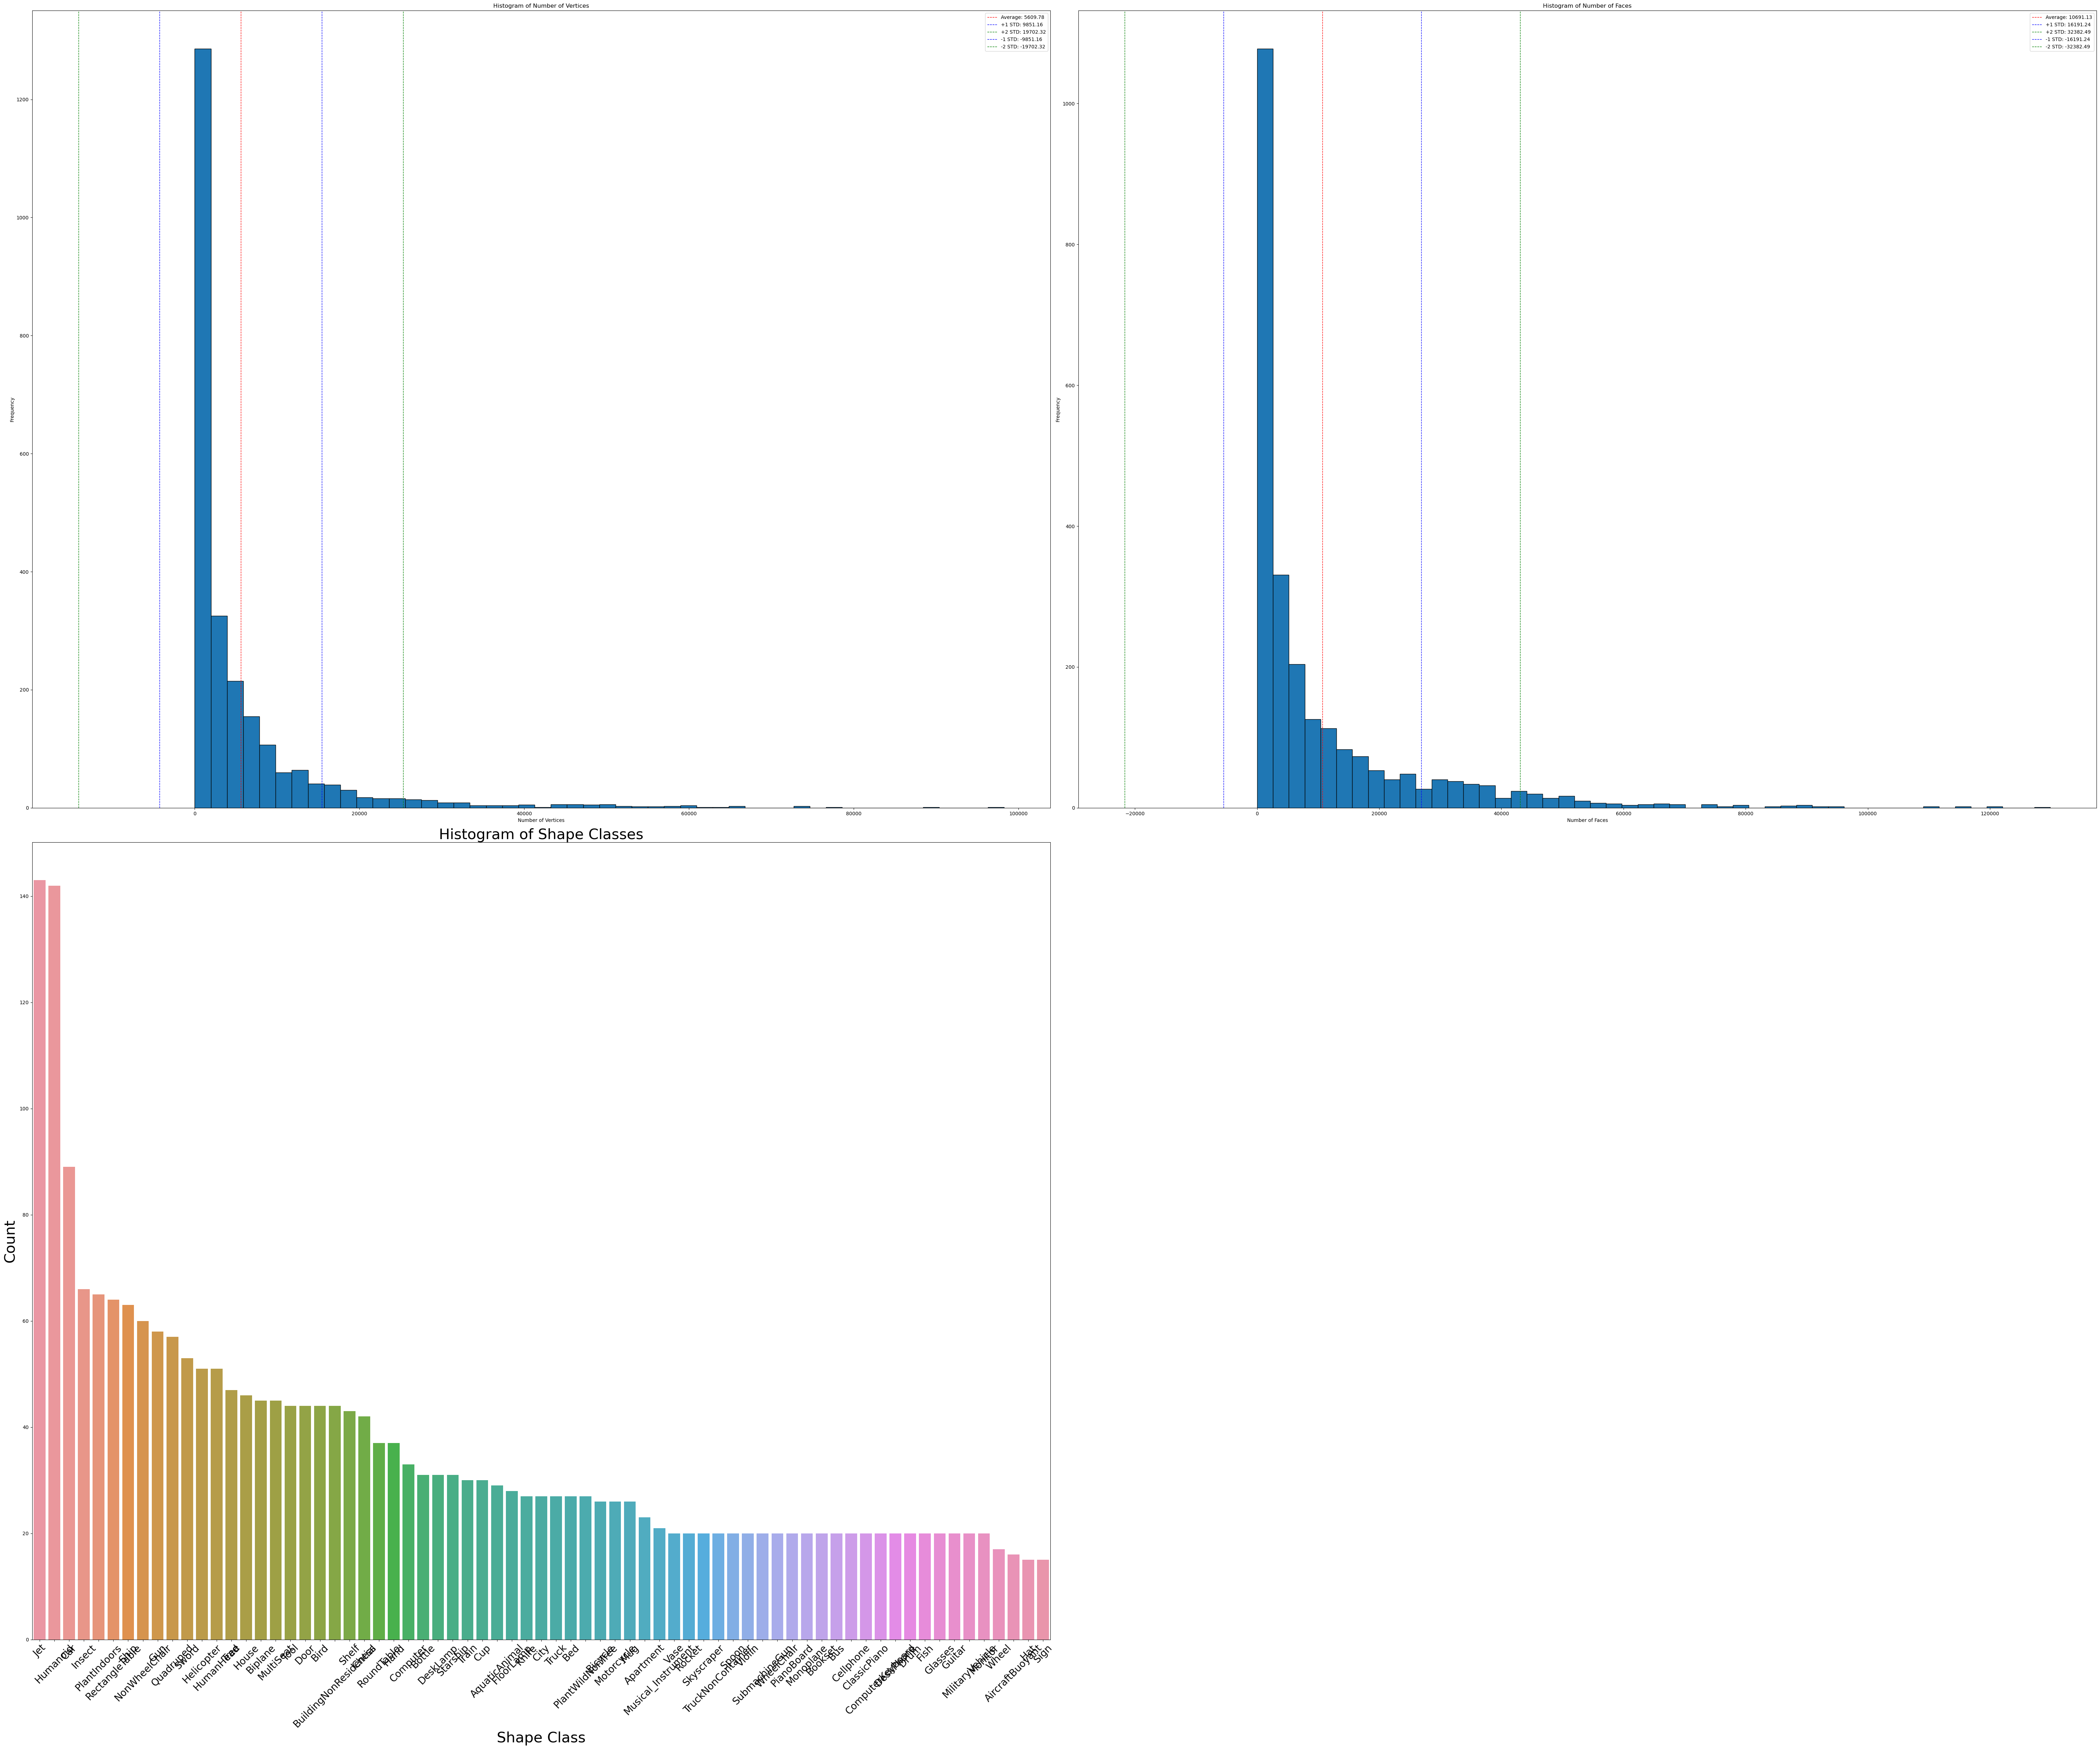

In [8]:
run_histograms(df)

## Resumpling the meshes

In [2]:

def resample_mesh(mesh_path, target_vertices=10000):
    # Load the mesh using vedo
    mesh = vedo.load(mesh_path)
    prev_mesh=mesh

    # Get the initial number of vertices
    initial_vertex_count = mesh.npoints
    resampled_vertex_count = initial_vertex_count

    # Close holes if there are any
    mesh.fill_holes(size=1)  # Adjust the size of holes to be filled (0.1 means small holes)
    mesh.clean()  # Remove duplicate vertices and degenerate faces
    mesh.triangulate()  # Ensure all faces are triangles for better decimation performance

  #  mesh.clean()
  #  mesh.smooth(niter=1000)  # Apply a smoothing operation with 10 iterations
    mesh.compute_normals()

    if initial_vertex_count > target_vertices:
        # Subsampling: Decimate the mesh to reduce the number of vertices
        mesh = mesh.decimate(fraction=target_vertices/initial_vertex_count)
        resampled_vertex_count = mesh.npoints
        print(f"Subsampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")

    elif initial_vertex_count < target_vertices:

        # Supersampling: Subdivide the mesh until we reach the target vertex count
        iterations = 1
        while mesh.npoints < target_vertices and iterations <= 10:
            mesh = mesh.subdivide(method=4)  # Loop subdivision (method=1)  subdividing as ’centroid’
            iterations += 1
            resampled_vertex_count = mesh.npoints

        # After subdivision, we may overshoot the target, so decimate to exactly match the target
        if mesh.npoints > target_vertices:
            mesh = mesh.decimate(fraction=target_vertices/mesh.npoints)
        if mesh.npoints==0: # if something goes wrong keep the initial shape
            print("here")
            mesh=vedo.load(mesh_path)
            resampled_vertex_count = mesh.npoints
        resampled_vertex_count = mesh.npoints
        print(f"Supersampling done. Initial vertices: {initial_vertex_count}, Resampled vertices: {resampled_vertex_count}")
    #mesh.fill_holes(size=1)
    # Save the resampled mesh
    #mesh.smooth(niter=100)
    mesh.compute_normals()
    resampled_mesh_path = ""
    if "query" not in mesh_path:
      resampled_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master", "ShapeDatabase_INFOMR-master_resumpled")
    else:
      resampled_mesh_path = mesh_path
    

    # Ensure the output directory exists
    output_dir = os.path.dirname(resampled_mesh_path)
    os.makedirs(output_dir, exist_ok=True)
    # Save the mesh in .obj format
    vedo.write(mesh, resampled_mesh_path)
    print(f"Final resampled mesh saved to: {resampled_mesh_path}, Vertices: {resampled_vertex_count}")

    return resampled_mesh_path

## Resampling all the meshes

In [10]:
def process_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    resample_mesh(mesh_path)


## Processing the Meshes

In [11]:
base_path = "./data/ShapeDatabase_INFOMR-master"
process_all_meshes(base_path)

Supersampling done. Initial vertices: 201, Resampled vertices: 10001
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled\AircraftBuoyant\m1337.obj, Vertices: 10001
Supersampling done. Initial vertices: 8761, Resampled vertices: 10002
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled\AircraftBuoyant\m1338.obj, Vertices: 10002
Supersampling done. Initial vertices: 1878, Resampled vertices: 9641
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled\AircraftBuoyant\m1339.obj, Vertices: 9641
Supersampling done. Initial vertices: 778, Resampled vertices: 10003
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled\AircraftBuoyant\m1340.obj, Vertices: 10003
Supersampling done. Initial vertices: 425, Resampled vertices: 10000
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled\AircraftBuoyant\m1341.obj, Vertices: 10000
Supersampling done. Initial vertices: 1252, Resampled vertic

## Run statistics for the resumpled dataset

In [12]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
data = statistics(database_path)
df = pd.DataFrame(data)

# Save data to CSV
df.to_csv("./statistics/shape_database_stats_resumple.csv", index=False)

## Run the histogram after sampling

Average number of vertices: 7778.423076923077
Average number of faces: 15442.725332259364
min number of vertices: 16
min number of faces: 16
max number of vertices: 98256
max number of faces: 129881
Standard deviation of vertices: 7318.719105928572
Standard deviation of faces: 12621.343301208393
Outliers in vertices count:
        Filename  Number of Vertices Shape Class
25    D00626.obj               73184   Apartment
97    D00040.obj               25426     Bicycle
99    D00078.obj               22674     Bicycle
100   D00462.obj               56754     Bicycle
102   D00536.obj               30832     Bicycle
...          ...                 ...         ...
2465  D00088.obj               26911  WheelChair
2471  D00394.obj               36064  WheelChair
2472  D00449.obj               27053  WheelChair
2477  D00628.obj               29552  WheelChair
2479  D00720.obj               43966  WheelChair

[139 rows x 3 columns]

Outliers in faces count:
        Filename  Number of Faces    

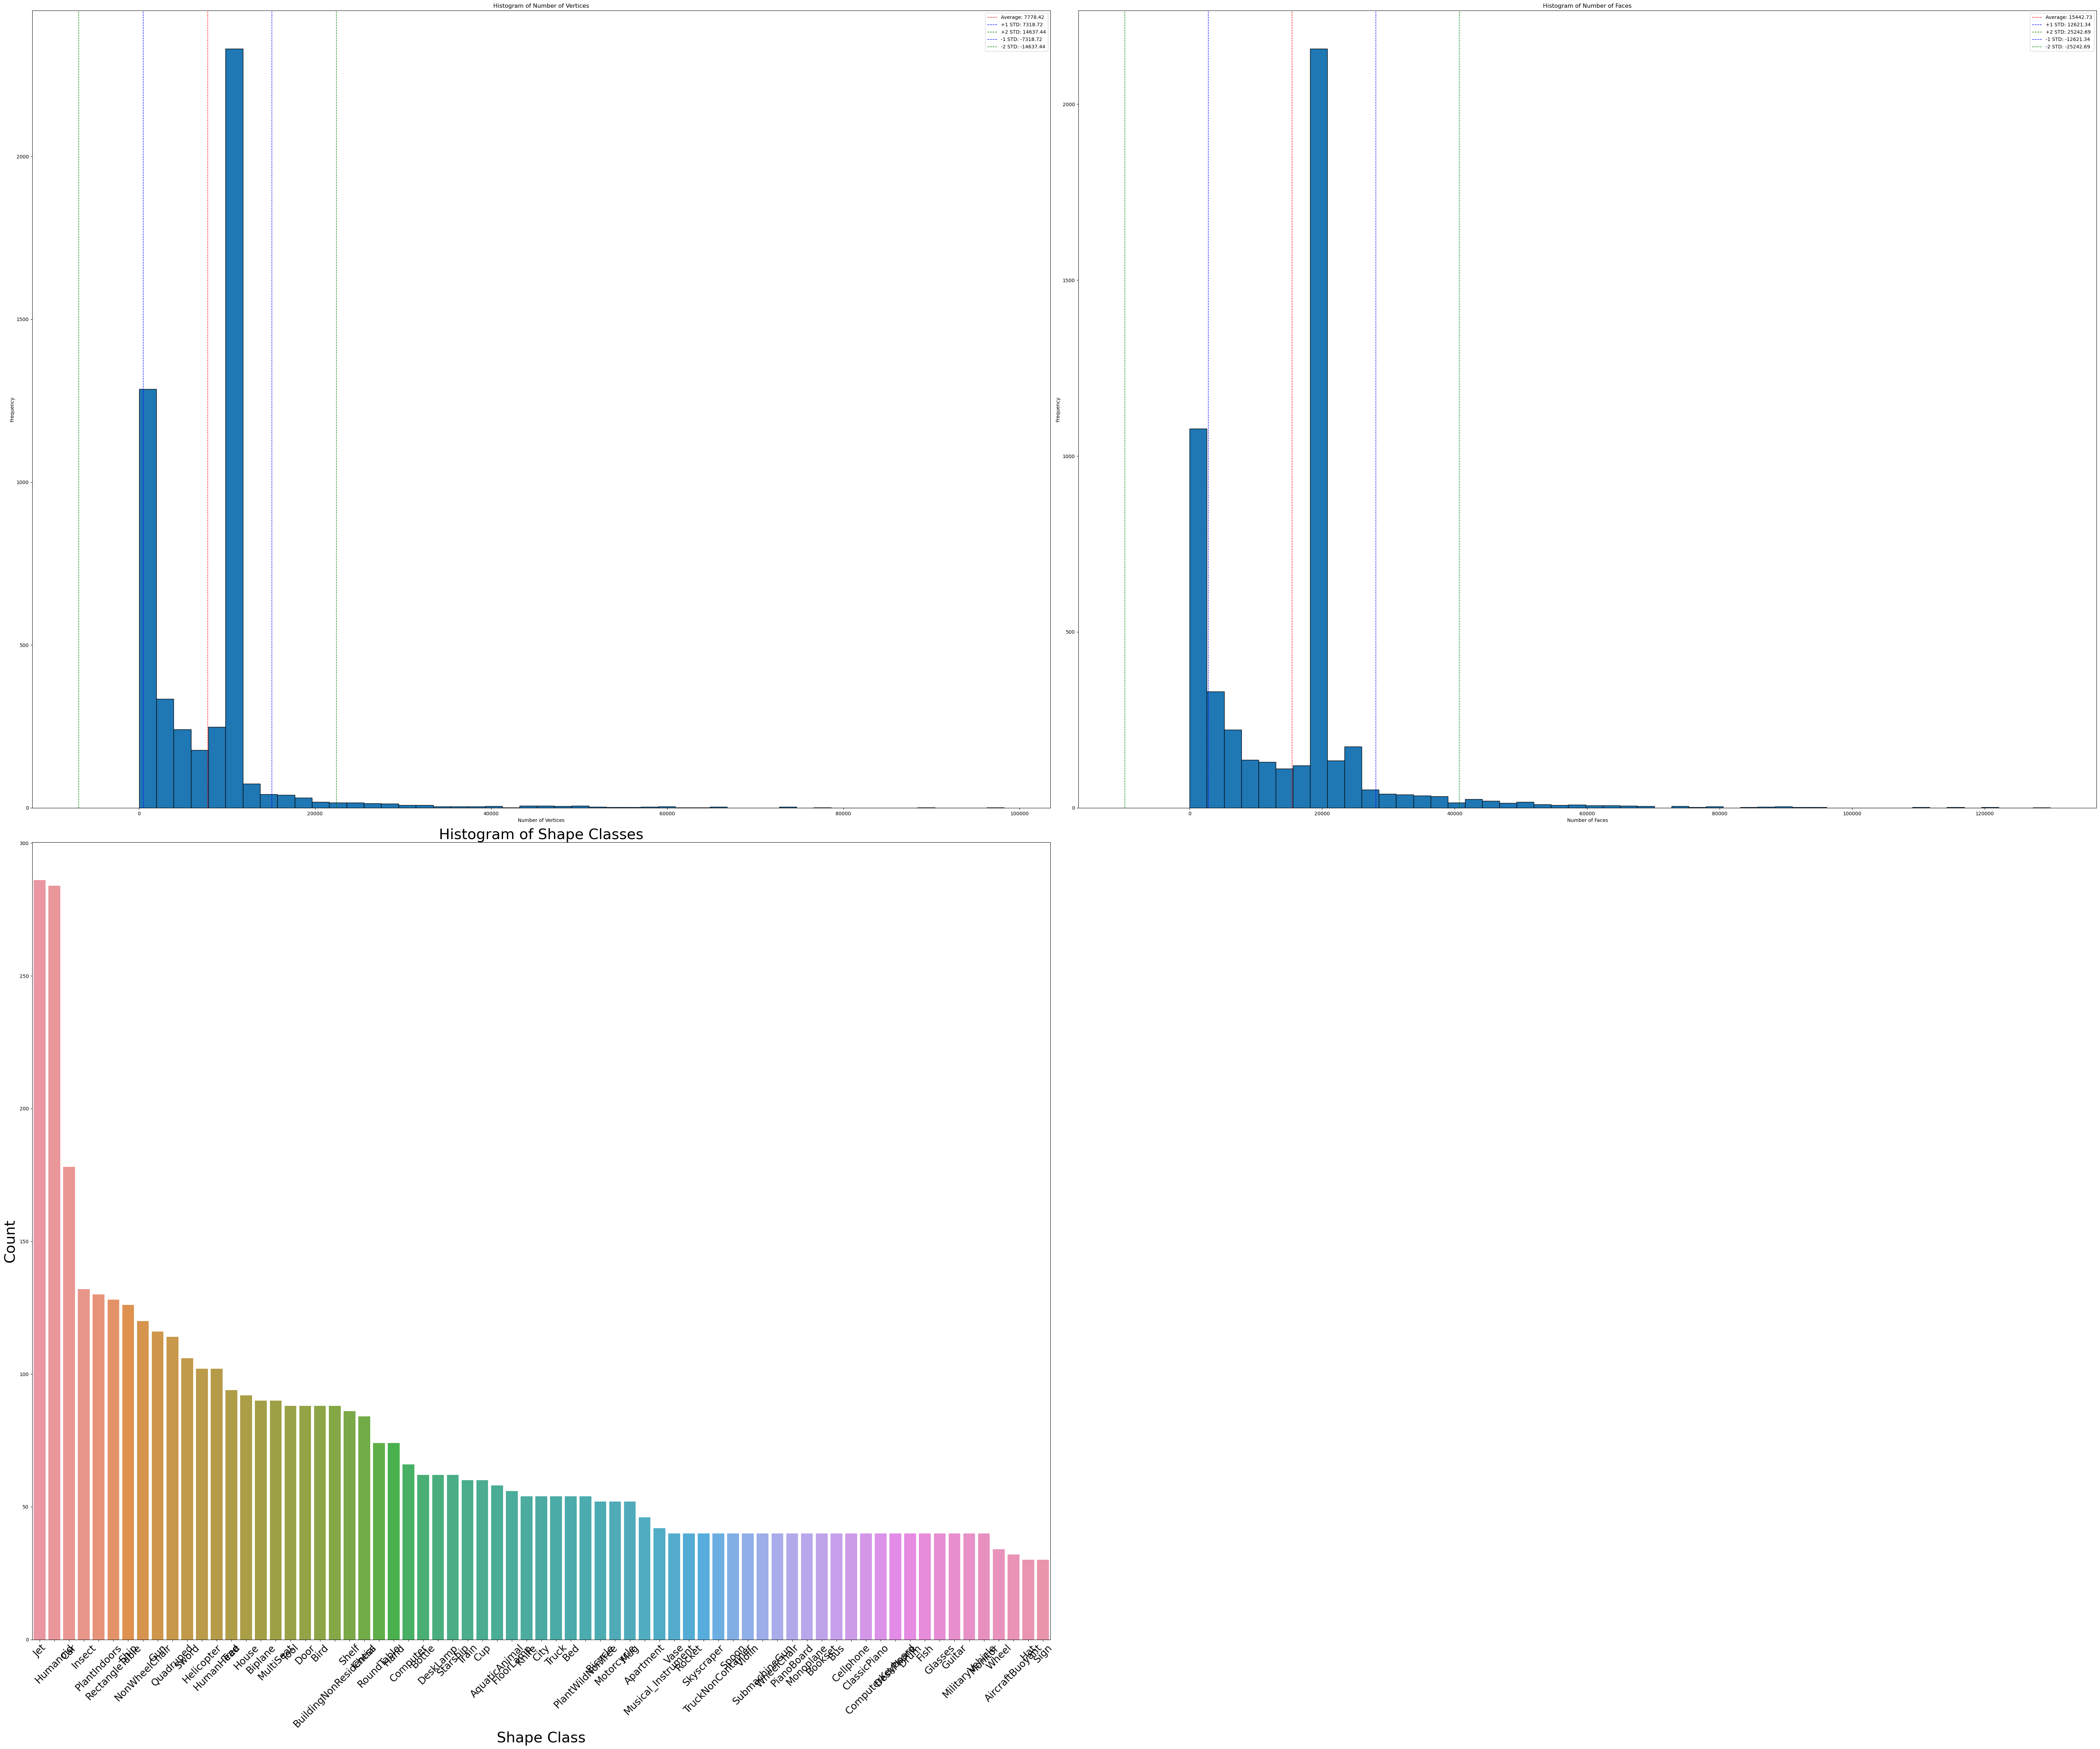

In [13]:
df= pd.read_csv("./statistics/shape_database_stats_resumple.csv")
run_histograms(df)

# Normalizing the meshes

In [3]:
def ComputePCA(mesh):
    vertices = np.asarray(mesh.vertices)
    cov = np.cov(vertices, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    eigencombined = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
    eigencombined.sort(key=lambda x: x[0], reverse=True)

    eigenvalues = [item[0] for item in eigencombined]
    eigenvectors = [item[1] for item in eigencombined]

    if len(eigenvectors) > 2:
        eigenvectors.pop(2) 
        third_vector = np.cross(eigenvectors[0], eigenvectors[1])
        eigenvectors.append(third_vector / np.linalg.norm(third_vector))  # Normalize the vector

    return eigenvalues, np.array(eigenvectors) 

In [4]:
def align_vertices(vertices,eigenvectors):
    aligned_vertices = np.zeros(vertices.shape)
    for i, p in enumerate(vertices):
        x_updated = np.dot(p, eigenvectors[0])  # Projection onto e1
        y_updated = np.dot(p, eigenvectors[1])  # Projection onto e2
        z_updated = np.dot(p, eigenvectors[2])  # Projection onto e3 (e1 x e2)
        # Store the updated vertex coordinates in the aligned vertices array
        aligned_vertices[i] = np.array([x_updated, y_updated, z_updated])
    return aligned_vertices

In [5]:
def compute_triangle_centroid(vertices, triangle):
    """Helper function to compute the centroid of a triangle."""
    v0 = vertices[triangle[0]]
    v1 = vertices[triangle[1]]
    v2 = vertices[triangle[2]]
    return (v0 + v1 + v2) / 3.0

In [6]:
def flip_mesh_by_volume(mesh):
    # Calculate the flipping values for each axis (x, y, z)
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        # Get the vertices of the face (triangle)
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        
        # Calculate the center of the triangle
        center = (v0 + v1 + v2) / 3
        
        # Add the center coordinates to the flipping values
        flipping_values += center

    # Determine the sign of each flipping value
    flipping_signs = np.sign(flipping_values)

    # Mirror along axes where flipping sign is negative
    for i, axis in enumerate("xyz"):
        if flipping_signs[i] < 0:
            mesh.mirror(axis=axis)

    return mesh  # Return the flipped mesh if needed


In [7]:
def normalize_shape(mesh_path):
    # Load the mesh
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return None

    # Step 1: Calculate the barycenter and translate the mesh to the origin
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)
    translated_vertices = np.asarray(mesh.vertices) - barycenter
    mesh.vertices = o3d.utility.Vector3dVector(translated_vertices)
    mesh.compute_vertex_normals()
    
    # Step 2: Align the mesh with principal axes using PCA
    eigenvalues, eigenvectors = ComputePCA(mesh)  # Ensure this function is defined
    aligned_vertices = align_vertices(translated_vertices, eigenvectors)  # Ensure this function is defined
    mesh.vertices = o3d.utility.Vector3dVector(aligned_vertices)
    mesh.compute_vertex_normals()
    
    # Save the translated and aligned mesh
    intermediate_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_intermediate")
    os.makedirs(os.path.dirname(intermediate_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(intermediate_mesh_path, mesh)
    
    # Load with Vedo for flipping
    vedo_mesh = vedo.Mesh(intermediate_mesh_path)
    
    # Step 3: Flip mesh along axes if needed
    flipped_mesh = flip_mesh_by_volume(vedo_mesh)  # Ensure this function is updated to use Vedo correctly
    
    # Save the flipped mesh
    flipped_mesh.write(intermediate_mesh_path)  # Save the Vedo mesh

    # Load flipped mesh back into Open3D
    flipped_mesh_o3d = o3d.io.read_triangle_mesh(intermediate_mesh_path)
    flipped_mesh_o3d.compute_vertex_normals()  # Compute normals if necessary

    # Step 4: Scale mesh to fit within a unit cube, centered at the origin
    bounds = flipped_mesh_o3d.get_axis_aligned_bounding_box()
    max_bound = bounds.get_max_bound()
    min_bound = bounds.get_min_bound()
    max_dimension = np.max(max_bound - min_bound)
    scale_factor = 1 / max_dimension  # Scale to fit within the unit cube
    flipped_mesh_o3d.scale(scale_factor, center=[0,0,0])  # Scale around the barycenter

    # Compute normals after scaling
    flipped_mesh_o3d.compute_vertex_normals()
    # Step 5: Save the normalized mesh
    normalized_mesh_path = ""
    if "query" not in mesh_path:
      normalized_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_resumpled", "ShapeDatabase_INFOMR-master_normalized")
    else:
      normalized_mesh_path = mesh_path
    os.makedirs(os.path.dirname(normalized_mesh_path), exist_ok=True)
    o3d.io.write_triangle_mesh(normalized_mesh_path, flipped_mesh_o3d)

    return normalized_mesh_path

## Normalizing all the meshes

In [301]:
def norm_all_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    normalize_shape(mesh_path)

In [92]:
mesh_path = r"./data/ShapeDatabase_INFOMR-master_resumpled/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
normalize_shape(mesh_path)
mesh_path = r"./data/ShapeDatabase_INFOMR-master_normalized/Door/m1717.obj"
visualize_mesh_with_unit_bbox(mesh_path)
mesh = o3d.io.read_triangle_mesh(mesh_path)
vedo_mesh = vedo.Mesh(mesh_path)
print(verify_translation(mesh),verify_scaling(mesh,mesh_path),verify_alignment(mesh),verify_flipping(vedo_mesh))


[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
(True, 3.071210323346786e-05) True True True


## Processing the Meshes

In [304]:
database_path= "./data/ShapeDatabase_INFOMR-master_resumpled"
norm_all_meshes(database_path)

[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write O

## Run statistics for the normalized dataset

In [22]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = statistics(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/shape_database_stats_norm.csv", index=False)

## Validation

In [8]:
def verify_translation(mesh, threshold=2e-3):
    # Compute barycenter
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)

    # Distance from origin
    distance_to_origin = np.linalg.norm(barycenter)
    return distance_to_origin <= threshold, distance_to_origin

In [9]:
def verify_scaling(mesh,mesh_path ,margin=1e-4):
    # Get bounding box
    bounding_box = mesh.get_axis_aligned_bounding_box()
    min_bound = bounding_box.get_min_bound()
    max_bound = bounding_box.get_max_bound()

    # Calculate the size along each axis
    bbox_size = max_bound - min_bound
    bbox_x, bbox_y, bbox_z = bbox_size
    max_axis=max(bbox_x, bbox_y, bbox_z)
    if ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))==False:
        print("This mesh doesnot fit: ",mesh_path)

    # Check if bounding box fits within unit cube, with a margin
    return ((bbox_x <= 1+1e-4 and bbox_y <= 1+1e-4 and bbox_z <= 1+1e-4)and(max_axis>=1- 1e-4))

In [10]:
def verify_alignment(mesh, threshold=1e-4):
    vertices = np.asarray(mesh.vertices)
    eigenvalues, eigenvectors = ComputePCA(mesh)
    x_axis = np.array([1, 0, 0])
    y_axis = np.array([0, 1, 0])
    z_axis = np.array([0, 0, 1])
    dot_x = np.abs(np.dot(eigenvectors[0], x_axis))
    dot_y = np.abs(np.dot(eigenvectors[1], y_axis))
    dot_z = np.abs(np.dot(eigenvectors[2], z_axis))
    aligned_x = dot_x >= threshold
    aligned_y = dot_y >= threshold
    aligned_z = dot_z >= threshold
    return aligned_x and aligned_y and aligned_z

In [11]:
def verify_flipping(mesh):
    # Initialize flipping values for each axis (x, y, z)
    flipping_values = np.zeros(3)
    
    for face in mesh.cells:
        # Get the vertices of the face (triangle)
        v0, v1, v2 = [np.array(mesh.points()[i]) for i in face]
        
        # Calculate the center of the triangle
        center = (v0 + v1 + v2) / 3
        
        # Add the center coordinates to the flipping values
        flipping_values += center

    # Check if all flipping values are positive
    positive_check = np.all(flipping_values >= 0)
    return positive_check

In [12]:
def analyze_shapes(database_path):
    # Arrays to store results
    translation_results = []
    translation_distances = []
    scaling_results = []
    alingment_results = []
    flipping_results = []

    # Traverse through each shape class directory and process .obj files
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        # Load the mesh
                        mesh = o3d.io.read_triangle_mesh(mesh_path)
                        vedo_mesh = vedo.Mesh(mesh_path)
                        # Verify translation
                        translation_ok, distance_to_origin = verify_translation(mesh)
                        scaling_ok = verify_scaling(mesh,mesh_path)
                        aligning_ok = verify_alignment(mesh)
                        flip_ok = verify_flipping(vedo_mesh)
                        #adding verification for alignment and flipping
                        
                        # Store results
                        translation_results.append(translation_ok)
                        translation_distances.append(distance_to_origin)
                        scaling_results.append(scaling_ok)
                        alingment_results.append(aligning_ok)
                        flipping_results.append(flip_ok)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return translation_results, translation_distances, scaling_results,alingment_results,flipping_results

In [13]:
def plot_histograms(translation_results, translation_distances, scaling_results, alignment_results, flipping_results):
    # Create histograms for translation
    plt.figure(figsize=(12, 6))

    # Histogram for translation (distance to origin)
    plt.subplot(1, 2, 1)
    plt.hist(translation_distances, bins=20, color='skyblue', edgecolor='black')
    plt.axvline(x=2e-3, color='red', linestyle='--', label='Threshold')
    plt.title('Translation Check: Distance to Origin')
    plt.xlabel('Distance to Origin')
    plt.ylabel('Number of Shapes')
    plt.legend()

    # Success/Failure counts for translation
    plt.subplot(1, 2, 2)
    translation_results_numeric = [int(result) for result in translation_results]
    plt.hist(translation_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Translation Result: Barycenter at Origin')
    plt.xlabel('Translation Result')
    plt.ylabel('Number of Shapes')

    # Show the translation plots
    plt.tight_layout()
    plt.show()

    # Create histograms for scaling and alignment
    plt.figure(figsize=(12, 6))

    # Histogram for scaling (fit in unit cube)
    plt.subplot(1, 2, 1)
    scaling_results_numeric = [int(result) for result in scaling_results]
    plt.hist(scaling_results_numeric, bins=2, color='salmon', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Scaling Check: Fits in Unit Cube')
    plt.xlabel('Scaling Result')
    plt.ylabel('Number of Shapes')

    # Success/Failure counts for alignment
    plt.subplot(1, 2, 2)
    alignment_results_numeric = [int(result) for result in alignment_results]
    plt.hist(alignment_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Alignment Result: Align along the XYZ Axis')
    plt.xlabel('Alignment Result')
    plt.ylabel('Number of Shapes')

    # Show the scaling and alignment plots
    plt.tight_layout()
    plt.show()

    # Success/Failure counts for flipping
    plt.figure(figsize=(6, 6))
    flipping_results_numeric = [int(result) for result in flipping_results]
    plt.hist(flipping_results_numeric, bins=2, color='lightgreen', edgecolor='black')
    plt.xticks([0, 1], ['Failed', 'Passed'])
    plt.title('Flipping Result: Flipped Shapes')
    plt.xlabel('Flipping Result')
    plt.ylabel('Number of Shapes')

    # Show the flipping plot
    plt.tight_layout()
    plt.show()

Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.
Flipping was successful; the mesh mass is mostly in the positive half-space.

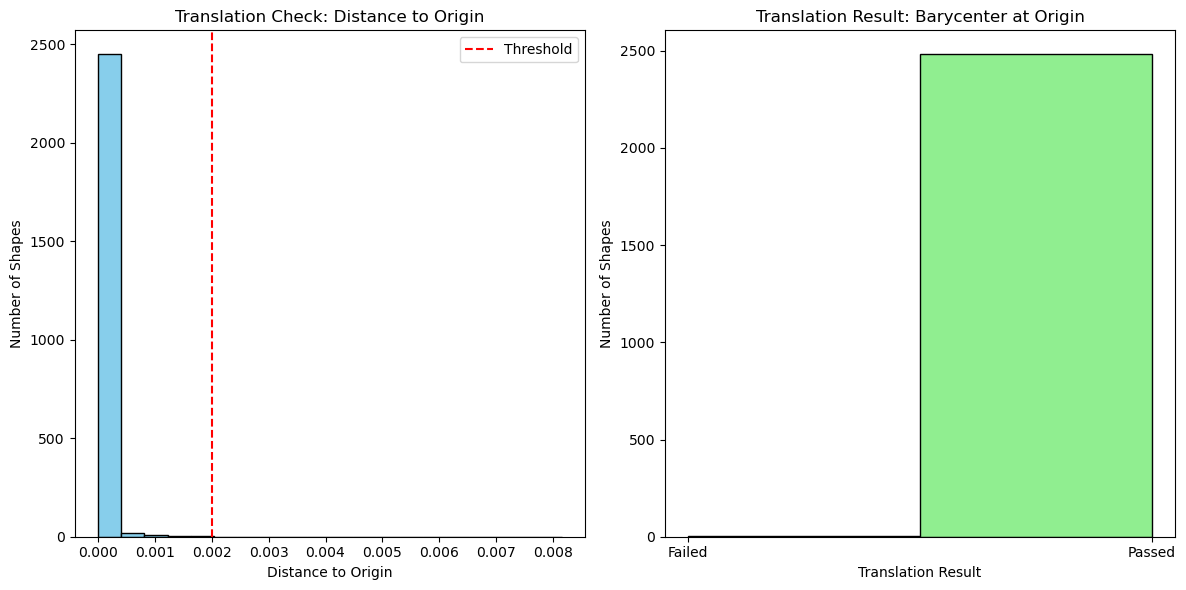

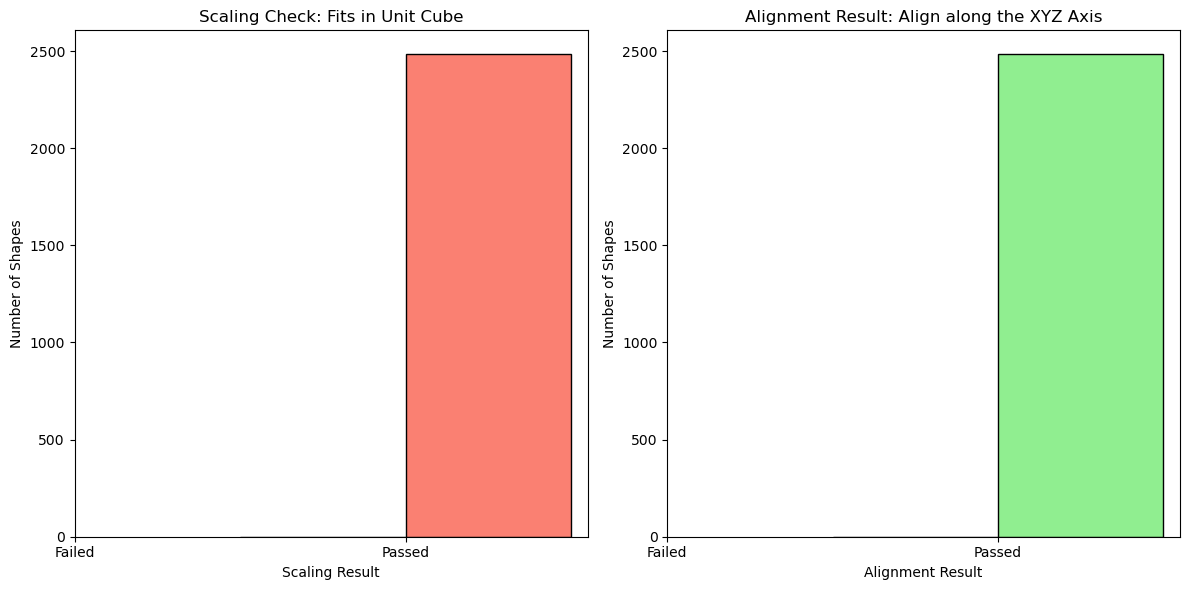

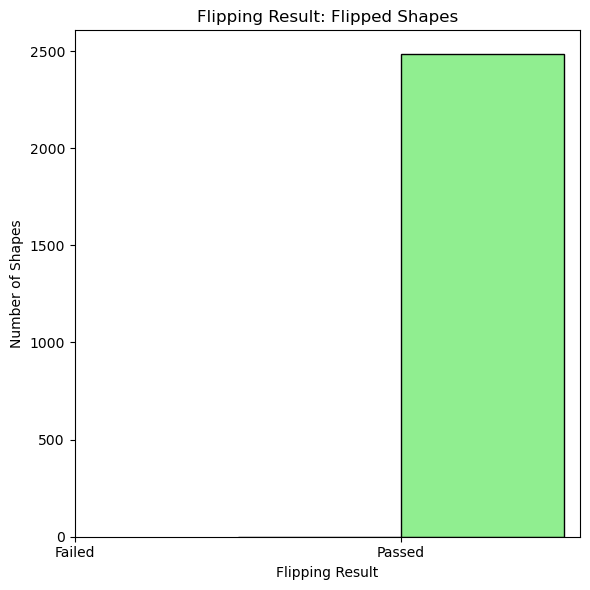

In [308]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
translation_results, translation_distances, scaling_results,alingment_results,flipping_results = analyze_shapes(database_path)
plot_histograms(translation_results, translation_distances, scaling_results,alingment_results,flipping_results)

In [309]:
flipping_results.count(False)

0

## Check the bounding box sizes distribution (Mean and STD) before and after normalization

In [14]:
def b_box_size(mesh):
    # Get the axis-aligned bounding box
    bounding_box = mesh.get_axis_aligned_bounding_box()
    # Compute the size of the bounding box via its diagonal
    size = np.linalg.norm(bounding_box.get_max_bound() - bounding_box.get_min_bound())
    return size

In [15]:
def analyze_bounding_box_sizes(database_path):
    # List to store bounding box sizes
    bounding_box_sizes = []

    # Traverse through each shape class directory and process .obj files
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    try:
                        # Load the mesh
                        mesh = o3d.io.read_triangle_mesh(mesh_path)

                        # Compute the size of the bounding box
                        size = b_box_size(mesh)
                        bounding_box_sizes.append(size)

                    except Exception as e:
                        print(f"Error processing {mesh_path}: {e}")

    return bounding_box_sizes

In [16]:
def plot_bounding_box_size_histogram(bounding_box_sizes):
    # Create histogram
    plt.figure(figsize=(8, 6))
    plt.hist(bounding_box_sizes, bins=20, color='lightblue', edgecolor='black')
    plt.title('Bounding Box Size Histogram')
    plt.xlabel('Bounding Box Size (Diagonal Length)')
    plt.ylabel('Number of Shapes')
    plt.axvline(x=np.mean(bounding_box_sizes), color='red', linestyle='--', label='Mean Size')
    plt.axvline(x=math.sqrt(3), color='green', linestyle='--', label='Diagonal of a unit cube')
    plt.legend()
    plt.tight_layout()
    plt.show()

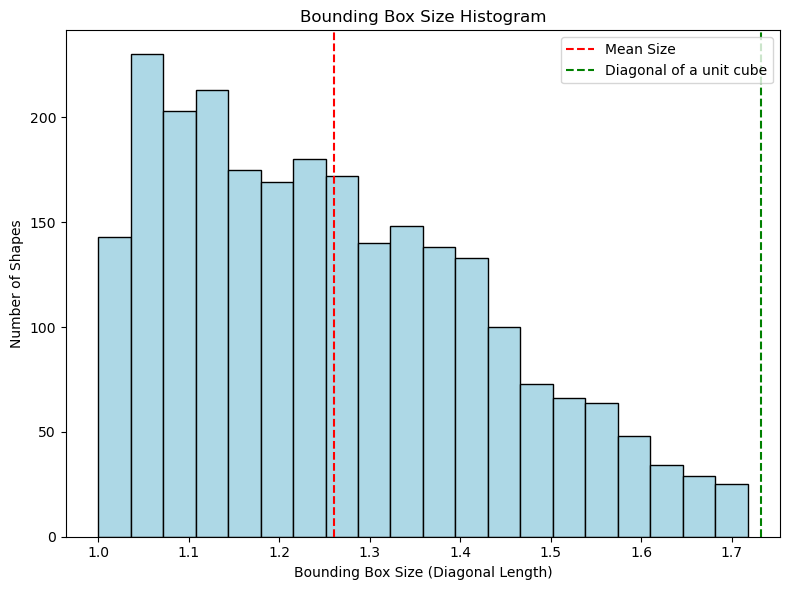

In [26]:
database_path = "./data/ShapeDatabase_INFOMR-master_normalized"
bounding_box_sizes = analyze_bounding_box_sizes(database_path)
plot_bounding_box_size_histogram(bounding_box_sizes)

In [16]:
def calculate_statistics(bounding_box_sizes):
    mean_size = np.mean(bounding_box_sizes)
    std_size = np.std(bounding_box_sizes)
    return mean_size, std_size

In [28]:
# Calculate and print the mean and standard deviation
mean_size, std_size = calculate_statistics(bounding_box_sizes)
print(f"Mean Bounding Box Size: {mean_size}")
print(f"Standard Deviation of Bounding Box Sizes: {std_size}")

Mean Bounding Box Size: 1.260408437808104
Standard Deviation of Bounding Box Sizes: 0.17223927169084943


## Check the barycenter distances from its origin distribution (Mean and STD) before and after normalization

In [30]:
mean_baryC_distance=np.mean(translation_distances)
std_baryC_distance=np.std(translation_distances)
print(f"Mean Barycenter Distance from Origin: {mean_baryC_distance}")
print(f"Standard Deviation of Barycenter Distances: {std_baryC_distance}")

NameError: name 'translation_distances' is not defined

# we need to add opposite orientations

In [ ]:
# def check_opposite_orientations(mesh_path):
#     oppfaces=0
#     not_oppfaces=0
#     print(mesh_path)
#     # Load the mesh
#     mesh = o3d.io.read_triangle_mesh(mesh_path)
#     if mesh.is_empty():
#         print(f"Failed to load the mesh: {mesh_path}")
#         return None

#     # A dictionary to store edges and the corresponding face indices and orientations
#     edges = defaultdict(list)

#     # Traverse each face and store its edges
#     for face_idx, face in enumerate(mesh.triangles):
#         vertex_indices = face.tolist()

#         # Define edges (always store edges with the smaller index first to avoid duplicates)
#         edge1 = (min(vertex_indices[0], vertex_indices[1]), max(vertex_indices[0], vertex_indices[1]))
#         edge2 = (min(vertex_indices[1], vertex_indices[2]), max(vertex_indices[1], vertex_indices[2]))
#         edge3 = (min(vertex_indices[2], vertex_indices[0]), max(vertex_indices[2], vertex_indices[0]))

#         # Store the edges with orientation (True means original order, False means reversed)
#         edges[edge1].append((face_idx, vertex_indices[0] < vertex_indices[1]))
#         edges[edge2].append((face_idx, vertex_indices[1] < vertex_indices[2]))
#         edges[edge3].append((face_idx, vertex_indices[2] < vertex_indices[0]))

#     # Now check for opposite orientations of edges
#     opposite_orientations = []
#     for edge, face_info in edges.items():
#         if len(face_info) == 2:  # The edge is shared by two faces
#             (face1_idx, face1_orientation), (face2_idx, face2_orientation) = face_info
#             if face1_orientation == face2_orientation:  # Same orientation means opposite face orientation
#                 opposite_orientations.append((face1_idx, face2_idx, edge))

#     # Output the result
#     if opposite_orientations:
#        oppfaces=1

#     else:
#         not_oppfaces=1
#     return oppfaces, not_oppfaces

In [ ]:
# # Load or create your mesh
# mesh = o3d.geometry.TriangleMesh.create_sphere()  # Example mesh

# # A dictionary to store edges and the corresponding face indices and orientations
# def fix_mesh_orientation(mesh_path):
#     # Load the mesh
#     mesh = o3d.io.read_triangle_mesh(mesh_path)
#     if mesh.is_empty():
#         print(f"Failed to load the mesh: {mesh_path}")
#         return None
#     # Create a dictionary to store edges and the corresponding face indices and orientations
#     edges = defaultdict(list)

#     # Traverse each face and store its edges
#     for face_idx, face in enumerate(mesh.triangles):
#         vertex_indices = face.tolist()

#         # Define edges (always store edges with the smaller index first to avoid duplicates)
#         edge1 = (min(vertex_indices[0], vertex_indices[1]), max(vertex_indices[0], vertex_indices[1]))
#         edge2 = (min(vertex_indices[1], vertex_indices[2]), max(vertex_indices[1], vertex_indices[2]))
#         edge3 = (min(vertex_indices[2], vertex_indices[0]), max(vertex_indices[2], vertex_indices[0]))

#         # Store the edges with orientation (True means original order, False means reversed)
#         edges[edge1].append((face_idx, vertex_indices[0] < vertex_indices[1]))
#         edges[edge2].append((face_idx, vertex_indices[1] < vertex_indices[2]))
#         edges[edge3].append((face_idx, vertex_indices[2] < vertex_indices[0]))

#     # Mark all faces as unvisited
#     visited = [False] * len(mesh.triangles)

#     def flip_face(face):
#         """Flip the face by reversing its vertices."""
#         return [face[2], face[1], face[0]]

#     def bfs(start_face):
#         """Breadth-first search to fix orientations."""
#         queue = deque([start_face])
#         visited[start_face] = True

#         while queue:
#             face_idx = queue.popleft()
#             current_face = mesh.triangles[face_idx]

#             # Iterate through each edge of the current face
#             for i in range(3):
#                 v0, v1 = current_face[i], current_face[(i + 1) % 3]
#                 edge = (min(v0, v1), max(v0, v1))

#                 # Get all faces sharing this edge
#                 adjacent_faces = edges[edge]

#                 for adj_face_idx, adj_orientation in adjacent_faces:
#                     if adj_face_idx == face_idx or visited[adj_face_idx]:
#                         continue  # Skip the current face or already visited faces

#                     adj_face = mesh.triangles[adj_face_idx]

#                     # Check if orientations are inconsistent
#                     current_orientation = v0 < v1
#                     if current_orientation == adj_orientation:
#                         # Orientations are the same, so flip the adjacent face
#                         mesh.triangles[adj_face_idx] = flip_face(adj_face)

#                     # Mark the adjacent face as visited and add it to the queue
#                     visited[adj_face_idx] = True
#                     queue.append(adj_face_idx)

#     # Find and fix all connected components
#     for face_idx in range(len(mesh.triangles)):
#         if not visited[face_idx]:
#             bfs(face_idx)
#     mesh.compute_vertex_normals()
#     # Save the normalized mesh
#     normalized_mesh_path = mesh_path.replace("ShapeDatabase_INFOMR-master_normalized", "ShapeDatabase_INFOMR-master_normalized_fixedOrientation")
#     os.makedirs(os.path.dirname(normalized_mesh_path), exist_ok=True)
#     o3d.io.write_triangle_mesh(normalized_mesh_path, mesh)

In [ ]:
# def fix_all_meshes(database_path):
#     for shape_class in os.listdir(database_path):
#         shape_class_path = os.path.join(database_path, shape_class)
#         if os.path.isdir(shape_class_path):
#             for filename in os.listdir(shape_class_path):
#                 if filename.endswith(".obj"):  # Check for .obj files
#                     mesh_path = os.path.join(shape_class_path, filename)
#                     print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
#                     fix_mesh_orientation(mesh_path)
# database_path= "C:/Users/panos/Downloads/Multimedia retrival/Labs/ShapeDatabase_INFOMR-master_normalized"
# fix_all_meshes(database_path)

In [ ]:
# def check_orientation_all(database_path):
#     op=0
#     not_op=0
#     for shape_class in os.listdir(database_path):
#         print(shape_class)
#         shape_class_path = os.path.join(database_path, shape_class)
#         if os.path.isdir(shape_class_path):
#             print(shape_class_path)
#             for filename in os.listdir(shape_class_path):
#                 if filename.endswith(".obj"):  # Check for .obj files
#                     mesh_path = os.path.join(shape_class_path, filename)
#                     print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
#                     opp,not_opp=check_opposite_orientations(mesh_path)
#                     op=op+opp
#                     not_op=not_op+not_opp
#     print("oposite faces",op)
#     print("same direction faces",not_op)
#     return op,not_op


# database_path= "C:/Users/panos/Downloads/Multimedia retrival/Labs/ShapeDatabase_INFOMR-master_normalized_fixedOrientation"
# op,not_op=check_orientation_all(database_path)

## visualizing the mehses before and after normalization

In [18]:
def visualize_mesh_with_unit_bbox(mesh_path):
    # Load the mesh
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    if mesh.is_empty():
        print(f"Failed to load the mesh: {mesh_path}")
        return

    # Step 1: Calculate the barycenter
    barycenter = np.mean(np.asarray(mesh.vertices), axis=0)

    # Compute the bounding box of the mesh
    mesh_bbox = mesh.get_axis_aligned_bounding_box()

    # Set the bounding box color to red (for the actual mesh bounding box)
    mesh_bbox.color = np.array([1, 0, 0])  # Red color

    # Create a unit cube representing the unit bounding box [-0.5, 0.5] in each dimension
    unit_bbox = o3d.geometry.AxisAlignedBoundingBox(min_bound=[-0.5, -0.5, -0.5], max_bound=[0.5, 0.5, 0.5])
    unit_bbox.color = np.array([0, 1, 0])  # Green color for the unit cube

    # Create a coordinate frame (axis)
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1)

    # Create a visualization
    vis = o3d.visualization.Visualizer()
    vis.create_window()

    # Add the mesh, its bounding box, the unit cube, and the axes to the visualizer
    vis.add_geometry(mesh)
    #vis.add_geometry(mesh_bbox)
    vis.add_geometry(unit_bbox)
    vis.add_geometry(axis)
    # Slightly displace the wireframe mesh to avoid z-fighting (mimicking OpenGL offset)
    wireframe = o3d.geometry.LineSet.create_from_triangle_mesh(mesh)
    wireframe.paint_uniform_color([0, 0, 0])  # Set wireframe color
    vis.add_geometry(wireframe)

    # Run the visualizer
    vis.run()
    vis.destroy_window()

In [33]:
mesh_path = "./data/ShapeDatabase_INFOMR-master_normalized/Bus/D00264.obj"
visualize_mesh_with_unit_bbox(mesh_path)

# Part 3.2.1

In [17]:
def compute_obb_volume(mesh):
    # Load the mesh and extract vertex positions
    vertices = np.asarray(mesh.vertices)

 
    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)
   
    # Sort the eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    principal_axes = eigenvectors[:, sorted_indices]
    
    # Calculate the AABB in the new basis
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    
    # Calculate the extents of the OBB
    obb_extents = max_coords - min_coords
    
    # Compute the volume of the OBB
    obb_volume = np.prod(obb_extents)
    
    return obb_volume

In [18]:
def compute_diameter(mesh):

    vertices = np.array(mesh.vertices)
    distances = np.linalg.norm(vertices[:, np.newaxis] - vertices, axis=2)

    return np.max(distances)

In [19]:
def compute_eccentricity(mesh):
        
    eigenvalues, eigenvectors = ComputePCA(mesh)
    eigenvalues = np.array(eigenvalues)
    eigenvectors = np.array(eigenvectors)

    return np.max(eigenvalues)/np.min(eigenvalues)

In [20]:
def compute_all_feature_meshes(database_path):
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):  # Check for .obj files
                    mesh_path = os.path.join(shape_class_path, filename)
                    # print(f"Processing mesh: {mesh_path}")  # Print the current file being processed
                    normalize_shape(mesh_path)

In [21]:
# List to store data for each shape
def compute_features(database_path):
    data = []
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    # Append data to list
                    mesh = vedo.load(mesh_path)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    data.append({
                        "objectID": filename,
                        "area": mesh.area(),
                        "volume":mesh.volume(),
                        "compactness":pow(mesh.area(), 3) / (36 * np.pi * pow(mesh.volume(), 2)),
                        "rectangularity":mesh.volume() / compute_obb_volume(openmesh),
                        "convexity":mesh.volume() / vedo.ConvexHull(mesh).volume(),
                        "diameter":compute_diameter(mesh),
                        "eccentricity":compute_eccentricity(mesh)
                    })
    return data

In [39]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = compute_features(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/shape_database_elementary_attributes.csv", index=False)

In [22]:

def validate_data(data_path):
    df = pd.read_csv(data_path)
    volume_check_array = df['convexity'] > 1
    return volume_check_array.tolist()


In [56]:
database_path= "./statistics/shape_database_elementary_attributes.csv"
x = validate_data(database_path)
print(len(x), x.count(True), x.count(False))


2483 113 2370


# step 3.2.2
In this step we will calculate the descriptors of the shapes:
* a3 - we calculate the angles between 10,000 points.
* d1 - we calculate the distances between the barycenter and |vertices| random points on the mesh
* d2 - we calculate the distance between 10,000 random points
* d3 - we calculate the area of triangle made by three random points (100K)
* d4 - we calculate the volume of tetrahedron made by 4 random points (100K)

In [23]:
def calculate_angle(p1,p2,p3):
    # creating the angle p1p2p3
    vec1 = p1 - p2
    vec2 = p3 - p2
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        cos_theta = 0  # or handle this case as needed
    else:
        cos_theta = np.dot(vec1, vec2) / (norm1 * norm2)
    theta = np.arccos(cos_theta)    
    return np.degrees(theta)

In [24]:
def get_random_points(point_list, number_of_points):
    num_points = len(point_list)
    idx_list = [random.randint(0, num_points-1) for n in range(0,number_of_points)]

    if len(set(idx_list)) < number_of_points:
        return get_random_points(point_list, number_of_points)
    
    return [point_list[a_idx] for a_idx in idx_list]

In [25]:
def a3(mesh):
    # within this function we are calculating the the angle descriptor
    result = []
    points = np.asarray(mesh.vertices)
    sample_size = 10000
    for i in range(sample_size):
        r = get_random_points(points, 3)
        a = calculate_angle(*r)
        result.append(a)
    return result    
    

In [26]:
def calculate_distance(point1, point2):
    # Calculate Euclidean distance between two points in 3D space
    return math.sqrt(sum((p2 - p1) ** 2 for p1, p2 in zip(point1, point2)))    

In [27]:
def d1(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    barycenter = np.mean(vertices, axis=0)
    sample_size = len(vertices)
    for i in range(sample_size):
        idx_p = random.randint(0, sample_size-1)
        result.append(calculate_distance(barycenter, vertices[idx_p]))
    return result

In [28]:
def d2(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_distance(*get_random_points(vertices, 2)))
    return result

In [29]:
def calculate_triangle_area(p1, p2, p3):
    # Calculate vectors AB and AC
    vec_AB = np.array(p2) - np.array(p1)
    vec_AC = np.array(p3) - np.array(p1)

    # Calculate the cross product
    cross_product = np.cross(vec_AB, vec_AC)

    # Calculate the area (half the magnitude of the cross product)
    area = 0.5 * np.linalg.norm(cross_product)
    return area  # No need for sqrt

In [30]:
def d3(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 10000
    for _ in range(sample_size):
        result.append(calculate_triangle_area(*get_random_points(vertices, 3)))
    return result

In [31]:
def calculate_tetrahedron_volume(point1, point2, point3, point4):
    # Create the matrix from the four points
    matrix = np.array([
        [point1[0], point1[1], point1[2], 1],
        [point2[0], point2[1], point2[2], 1],
        [point3[0], point3[1], point3[2], 1],
        [point4[0], point4[1], point4[2], 1]
    ])

    # Compute the determinant of the matrix
    determinant = np.linalg.det(matrix)

    # Calculate the volume (absolute value of the determinant divided by 6)
    volume = abs(determinant) / 6.0
    return volume

In [32]:
def d4(mesh):
    result = []
    vertices = np.asarray(mesh.vertices)
    sample_size = 100000
    for _ in range(sample_size):
        result.append(calculate_tetrahedron_volume(*get_random_points(vertices, 4)))
    return result

In [33]:
def calculate_histogram_features(mesh_object):
    rst = {"A3": a3(mesh_object),
           "D1": d1(mesh_object),
           "D2": d2(mesh_object),
           "D3": d3(mesh_object),
           "D4": d4(mesh_object),
           }
    # print(rst)

    return rst

In [34]:
def compute_descriptors(database_path):
    data = []
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    # Append data to list
                    # mesh = vedo.load(mesh_path)
                    openmesh = o3d.io.read_triangle_mesh(mesh_path)
                    data.append({
                        "objectID": filename,
                        "A3": a3(openmesh),
                        "D1": d1(openmesh),
                        "D2": d2(openmesh),
                        "D3": d3(openmesh),
                        "D4": d4(openmesh),
                    })            
    return data

In [35]:
# Assuming rst contains the A3 values
def plot_histogram(a3_values,key ,bins=30):
    plt.hist(a3_values, bins=bins, edgecolor='black', alpha=0.7)
    plt.title(f'{key} Descriptor Histogram')
    plt.xlabel('distance')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

In [57]:

database_path= "./data/ShapeDatabase_INFOMR-master_normalized"
data = compute_descriptors(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/shape_database_descriptors.csv", index=False)

In [36]:
def create_histogram(data, gmin, gmax, numOfBins=100):
    # Create histogram bins and counts
    counts, bin_edges = np.histogram(data, bins=numOfBins, range=(gmin, gmax))
    return counts

In [37]:
def return_global_min_max(Descriptor_features_df):
    global_min_max = []  # List to store global min/max for each column

    for column_index in range(1, len(Descriptor_features_df.columns)):  # Iterate through columns after the first one
        all_values = []
        
        for index in Descriptor_features_df.index:  # Iterate through rows
            value_list = Descriptor_features_df.iloc[index, column_index]

            if isinstance(value_list, list):  # Ensure the value is a list
                all_values.extend(value_list)
            else:
                print(f"Unexpected format in row {index}, column {column_index}: {value_list}")

        if all_values:  # Only calculate min/max if values are present
            global_min = min(all_values)
            global_max = max(all_values)
            global_min_max.append([global_min, global_max])
        else:
            global_min_max.append([None, None])  # Handle empty columns gracefully

    return global_min_max

In [38]:
def replace_with_bins(Descriptor_features_df, global_min_max):
    histogram_df = Descriptor_features_df.copy()

    for column_index in range(1, len(Descriptor_features_df.columns)):
        for index in Descriptor_features_df.index:
            value_list = Descriptor_features_df.iloc[index, column_index]

            if isinstance(value_list, list):  # Ensure the value is a list
                histogram = create_histogram(value_list, global_min_max[column_index - 1][0], global_min_max[column_index - 1][1])
                
                # Store the histogram in the copy of the DataFrame
                histogram_df.iloc[index, column_index] = histogram
            else:
                print(f"Unexpected format in row {index}, column {column_index}: {value_list}")
                histogram_df.iloc[index, column_index] = None  # Set to None if value is not a list
    return histogram_df

In [82]:
global_min_max=return_global_min_max(df)

In [85]:
Descriptor_features_df = replace_with_bins(df,global_min_max)

In [87]:
Descriptor_features_df.to_csv("./statistics/shape_database_descriptors_with_bins.csv", index=False)

In [83]:
global_min_max

[[7.194024615706825e-06, 179.9999711732839],
 [0.0001758038097206366, 1.0217423479121623],
 [3.898730773926076e-08, 1.5577814188372408],
 [0.0, 0.655530106002097],
 [0.0, 0.1903193113051239]]

In [86]:
Descriptor_features_df

,objectID,A3,D1,D2,D3,D4
0,m1337.obj,"[15, 58, 72, 75, 112, 113, 146, 147, 150, 164,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[9, 12, 26, 34, 39, 59, 89, 84, 94, 88, 106, 1...","[189, 341, 377, 421, 369, 330, 363, 337, 335, ...","[27592, 15750, 11188, 8604, 6990, 5558, 4575, ..."
1,m1338.obj,"[12, 24, 45, 57, 73, 98, 86, 107, 120, 136, 14...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 6, 26, 25, 34, 42, 46, 50, 46, 62, 79, 63,...","[95, 149, 213, 216, 230, 235, 259, 311, 281, 2...","[17168, 12561, 10532, 8927, 7487, 6695, 5673, ..."
2,m1339.obj,"[66, 126, 194, 186, 227, 200, 210, 197, 192, 1...","[354, 421, 324, 96, 173, 201, 130, 65, 50, 46,...","[96, 144, 138, 181, 171, 199, 236, 396, 519, 5...","[2030, 1856, 1421, 889, 656, 553, 501, 389, 29...","[85462, 8561, 3074, 1336, 714, 372, 186, 139, ..."
3,m1340.obj,"[138, 200, 264, 327, 320, 285, 213, 188, 159, ...","[0, 0, 0, 0, 0, 0, 0, 12, 8, 3, 552, 953, 1001...","[128, 296, 386, 438, 538, 517, 624, 800, 1185,...","[4385, 1203, 590, 744, 737, 729, 531, 384, 206...","[96312, 3192, 428, 59, 8, 1, 0, 0, 0, 0, 0, 0,..."
4,m1341.obj,"[137, 300, 396, 431, 373, 429, 346, 287, 263, ...","[0, 0, 0, 0, 0, 0, 309, 89, 63, 153, 58, 73, 4...","[39, 165, 226, 325, 376, 393, 481, 552, 513, 3...","[2591, 1897, 1783, 1242, 947, 617, 319, 235, 1...","[98585, 1291, 98, 22, 4, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
2478,D00687.obj,"[87, 148, 142, 114, 114, 135, 114, 152, 170, 1...","[0, 0, 0, 0, 0, 7, 7, 13, 41, 46, 60, 58, 81, ...","[36, 84, 91, 100, 97, 91, 51, 92, 80, 66, 119,...","[804, 746, 644, 651, 692, 688, 700, 624, 578, ...","[57719, 19505, 10620, 5995, 3110, 1645, 802, 4..."
2479,D00720.obj,"[39, 90, 84, 122, 117, 113, 130, 171, 147, 172...","[0, 11, 10, 14, 17, 48, 31, 52, 57, 100, 70, 7...","[20, 47, 72, 84, 95, 100, 103, 121, 126, 129, ...","[589, 816, 754, 830, 790, 743, 732, 692, 636, ...","[59243, 20128, 10410, 5505, 2591, 1161, 552, 2..."
2480,D00782.obj,"[181, 187, 137, 109, 91, 91, 87, 107, 125, 141...","[26, 55, 71, 84, 59, 22, 23, 22, 21, 16, 17, 2...","[88, 280, 150, 58, 38, 51, 37, 40, 52, 54, 69,...","[1217, 651, 406, 352, 416, 507, 642, 616, 455,...","[52982, 13816, 10903, 7262, 5426, 3190, 2517, ..."
2481,D00821.obj,"[99, 122, 134, 134, 107, 126, 118, 138, 158, 1...","[0, 0, 0, 0, 0, 3, 12, 23, 32, 36, 62, 68, 92,...","[45, 60, 82, 113, 87, 85, 69, 102, 75, 84, 106...","[808, 731, 695, 665, 682, 655, 626, 611, 568, ...","[58053, 19363, 10640, 5964, 3031, 1539, 780, 3..."


# Step 4: Querying

In [39]:
def read_elementary_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [40]:
def Standarize_el_features(el_Features_df):
    # Select the columns you want to normalize (columns 1 and after)
    cols_to_normalize = el_Features_df.columns[1:]

    # Create a StandardScaler object
    scaler = StandardScaler()

    # Fit the scaler to the selected columns and transform the data
    el_Features_df[cols_to_normalize] = scaler.fit_transform(el_Features_df[cols_to_normalize])
    return el_Features_df

In [41]:
def read_descriptor_features(file_path):
    df = pd.read_csv(file_path)
    return df

In [42]:
def calculate_emd(histogram1, histogram2):
  """
  Calculates the Earth Mover's Distance (EMD) between two histograms.

  Args:
    histogram1: A NumPy array representing the first histogram.
    histogram2: A NumPy array representing the second histogram.

  Returns:
    The EMD between the two histograms.
  """
  emd = wasserstein_distance(histogram1, histogram2)
  return emd

In [43]:
def emd_dist_of_descriptors(histogram_norm_df): # query shape will be always in the first row
    emd_distances = []  # Initialize an empty list to store EMD distances
    histogram_features_distances=histogram_norm_df.copy()
    # Iterate through each row of the DataFrame
    for column_index in range(1, len(histogram_norm_df.columns)):
      for index in range(histogram_norm_df.shape[0]):
          if isinstance(histogram_norm_df.iloc[0, column_index], str):
              Query_hist = np.fromiter(histogram_norm_df.iloc[0, column_index][1:-1].split(), dtype=float)
          else:
              Query_hist = histogram_norm_df.iloc[0, column_index]
          if isinstance(histogram_norm_df.iloc[index, column_index], str):
              Db_hist = np.fromiter(histogram_norm_df.iloc[index, column_index][1:-1].split(), dtype=float)
          else:
              Db_hist = histogram_norm_df.iloc[index, column_index]
          emd_distance = calculate_emd(Query_hist, Db_hist)
          histogram_features_distances.iloc[index, column_index] = emd_distance
    return histogram_features_distances

In [44]:
def norm_descriptors_distances(histogram_features_distances):
    # Select the columns you want to normalize (columns 1 and after)
    cols_to_normalize = histogram_features_distances.columns[1:]

    # Create a StandardScaler object
    scaler = StandardScaler()
    # Create the histogram_features_distances_stand DataFrame by copying the original
    histogram_features_distances_stand = histogram_features_distances.copy()

    # Fit the scaler to the selected columns and transform the data
    histogram_features_distances_stand[cols_to_normalize] = scaler.fit_transform(histogram_features_distances[cols_to_normalize])
    return histogram_features_distances_stand

In [45]:
def euclidean_distance(row1, row2):
  """
  Calculates the Euclidean distance between two feature vectors.

  Args:
    row1: A pandas Series representing the first feature vector.
    row2: A pandas Series representing the second feature vector.

  Returns:
    The Euclidean distance between the two vectors.
  """
  features1 = row1.iloc[1:].values  # Select features from column 1 and after
  features2 = row2.iloc[1:].values  # Select features from column 1 and after=
  distance = np.sqrt(np.sum((features1 - features2)**2))
  return distance

In [83]:
# def calculate_ef_distances(el_Features_df,histogram_features_distances_stand):
#     ef_distances = []  # Initialize an empty list to store EMD distances
#     All_features_dist=histogram_features_distances_stand.copy()
#     Query_hist =el_Features_df.iloc[0]
#     for index in range(el_Features_df.shape[0]):

#           Db_hist =el_Features_df.iloc[index]
#           ef_distance = euclidean_distance(Query_hist, Db_hist)
#           ef_distances.append(ef_distance)
#     # Convert the list of EMD distances to a NumPy array

#     All_features_dist['elementary_f_dist'] = ef_distances
#     # Calculate and add 'Total_distance' column
#     columns_to_sum = All_features_dist.columns[1:]
#     All_features_dist['Total_distance'] = All_features_dist[columns_to_sum].sum(axis=1)
#     return All_features_dist

def calculate_ef_distances(el_features_df, histogram_features_distances_stand):
    ef_distances = []  # Initialize an empty list to store distances
    All_features_dist = histogram_features_distances_stand.copy()
    
    # Define the query row as the first row
    Query_hist = el_features_df.iloc[0]
    
    # Calculate Euclidean distances and store in list
    for index in range(el_features_df.shape[0]):
        Db_hist = el_features_df.iloc[index]
        ef_distance = euclidean_distance(Query_hist, Db_hist)
        ef_distances.append(ef_distance)
    
    # Add calculated distances to the DataFrame
    All_features_dist['elementary_f_dist'] = ef_distances
    
    # Filter for numeric columns only to avoid issues during summation
    numeric_columns = All_features_dist.select_dtypes(include=['number']).columns
    
    # Calculate and add 'Total_distance' column
    All_features_dist['Total_distance'] = All_features_dist[numeric_columns].sum(axis=1)
    return All_features_dist

In [61]:
def get_shape_class(object_name, df):
    """
    Takes an object name and a CSV file path, and returns the corresponding
    value in the 'Shape Class' column for the given object.
    
    Parameters:
        object_name (str): The name of the object to search for.
        csv_file (str): The path to the CSV file.
        
    Returns:
        str or None: The shape class for the object if found, otherwise None.
    """
    # Search for the object in the DataFrame
    row = df[df['Filename'] == object_name]
    
    # Check if the object was found and return the corresponding 'Shape Class' value
    if not row.empty:
        return row['Shape Class'].values[0]
    else:
        return None

In [57]:
def compute_features_for_query(file_name,database_stats):
    data = []
    # Get the class of the mesh from the database
    mesh_class = get_shape_class(file_name, database_stats)
    if not mesh_class:
        print(f"Mesh class for '{file_name}' not found.")
        return data  # Return empty list if no class is found

    # Construct the full path to the mesh file
    mesh_path = f"./data/ShapeDatabase_INFOMR-master_normalized/{mesh_class}/{file_name}"

    try:
        # Load the mesh with vedo and Open3D
        mesh = vedo.load(mesh_path)
        openmesh = o3d.io.read_triangle_mesh(mesh_path)
        
        # Calculate features and append to the data list
        data.append({
            "objectID": file_name,
            "area": mesh.area(),
            "volume": mesh.volume(),
            "compactness": (mesh.area() ** 3) / (36 * np.pi * (mesh.volume() ** 2)),
            "rectangularity": mesh.volume() / compute_obb_volume(openmesh),
            "convexity": mesh.volume() / vedo.ConvexHull(mesh).volume(),
            "diameter": compute_diameter(mesh),
            "eccentricity": compute_eccentricity(mesh)
        })
    except Exception as e:
        print(f"Error loading or computing features for '{file_name}': {e}")

    return data

In [49]:
def compute_descriptors_for_query(file_name,database_stats):
    data = []
    # Traverse through all folders in the database
    mesh_class = get_shape_class(file_name, database_stats)
    if not mesh_class:
        print(f"Mesh class for '{file_name}' not found.")
        return data  # Return empty list if no class is found
    # Construct the full path to the mesh file
    mesh_path = f"./data/ShapeDatabase_INFOMR-master_normalized/{mesh_class}/{file_name}"
    try:
        # Load the mesh with vedo and Open3D
        openmesh = o3d.io.read_triangle_mesh(mesh_path)
        data.append({
            "objectID": filename,
            "A3": a3(openmesh),
            "D1": d1(openmesh),
            "D2": d2(openmesh),
            "D3": d3(openmesh),
            "D4": d4(openmesh),
        })
    except Exception as e:
        print(f"Error loading or computing descriptors for '{file_name}': {e}")
    df = pd.DataFrame(data)
    global_min_max=return_global_min_max(df)
    Descriptor_features_df = replace_with_bins(df,global_min_max)
    return Descriptor_features_df

# GUI To Upload a File

In [79]:
filepath = r"./data/ShapeDatabase_INFOMR-master_normalized_fixedOrientation/AircraftBuoyant/m1349.obj"
el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_with_bins.csv")
database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
filename = "m1349.obj"
resample_mesh(filepath)
normalize_shape(filepath)

# Extract features for the query mesh
query_features = compute_features_for_query(filename,database_stats)
query_hist_features = compute_descriptors_for_query(filename,database_stats)

# Prepare query dataframes
query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
el_Features_df.loc[0, 'objectID'] = "query.obj"
Descriptor_features_df.loc[0, 'objectID'] = "query.obj"


Supersampling done. Initial vertices: 432, Resampled vertices: 10002
Final resampled mesh saved to: ./data/ShapeDatabase_INFOMR-master_resumpled_normalized_fixedOrientation/AircraftBuoyant/m1349.obj, Vertices: 10002
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.


In [80]:
el_Features_df

,objectID,area,volume,compactness,rectangularity,convexity,diameter,eccentricity
0,query.obj,0.665413,0.027107,3.545259,0.293789,0.624346,1.000815,11.435438
1,m1337.obj,2.770102,0.335257,1.672161,0.410810,0.888407,1.020280,2.619286
2,m1338.obj,3.598979,0.369862,3.013054,0.407566,0.862189,1.046716,1.895304
3,m1339.obj,2.756522,0.093257,21.294764,0.241328,0.553637,1.000033,5.680690
4,m1340.obj,0.561354,0.027847,2.017036,0.221579,0.611325,1.000039,26.449918
...,...,...,...,...,...,...,...,...
2479,D00687.obj,1.865203,0.021646,122.454106,0.098833,0.204157,1.028435,5.642970
2480,D00720.obj,1.479590,0.029855,32.131211,0.118167,0.257855,1.013328,4.563161
2481,D00782.obj,1.336815,0.024047,36.528221,0.068887,0.160126,1.052129,2.962111
2482,D00821.obj,1.866261,0.021664,122.455301,0.099009,0.204449,1.028726,5.554821


In [81]:
Descriptor_features_df

,objectID,A3,D1,D2,D3,D4
0,query.obj,"[221, 261, 199, 156, 161, 165, 212, 250, 230, ...","[21, 8, 26, 31, 30, 60, 37, 38, 44, 33, 51, 30...","[133, 213, 131, 49, 58, 75, 69, 82, 102, 176, ...","[807, 426, 360, 317, 282, 235, 247, 230, 213, ...","[27866, 10691, 7126, 5643, 4733, 3971, 3474, 2..."
1,m1337.obj,[ 15 58 72 75 112 113 146 147 150 164 169 1...,[ 0 0 0 0 0 0 0 0 0 0 0 ...,[ 9 12 26 34 39 59 89 84 94 88 106 1...,[189 341 377 421 369 330 363 337 335 321 335 3...,[27592 15750 11188 8604 6990 5558 4575 37...
2,m1338.obj,[ 12 24 45 57 73 98 86 107 120 136 140 1...,[ 0 0 0 0 0 0 0 0 0 ...,[ 3 6 26 25 34 42 46 50 46 62 79 ...,[ 95 149 213 216 230 235 259 311 281 299 289 2...,[17168 12561 10532 8927 7487 6695 5673 50...
3,m1339.obj,[ 66 126 194 186 227 200 210 197 192 187 184 1...,[354 421 324 96 173 201 130 65 50 46 53 2...,[ 96 144 138 181 171 199 236 396 519 510 430 3...,[2030 1856 1421 889 656 553 501 389 295 ...,[85462 8561 3074 1336 714 372 186 1...
4,m1340.obj,[138 200 264 327 320 285 213 188 159 160 132 1...,[ 0 0 0 0 0 0 0 12 8 ...,[ 128 296 386 438 538 517 624 800 1185 ...,[4385 1203 590 744 737 729 531 384 206 ...,[96312 3192 428 59 8 1 0 ...
...,...,...,...,...,...,...
2479,D00687.obj,[ 87 148 142 114 114 135 114 152 170 157 167 1...,[ 0 0 0 0 0 7 7 13 41 46 60 ...,[ 36 84 91 100 97 91 51 92 80 66 119 1...,[804 746 644 651 692 688 700 624 578 564 487 5...,[57719 19505 10620 5995 3110 1645 802 4...
2480,D00720.obj,[ 39 90 84 122 117 113 130 171 147 172 166 1...,[ 0 11 10 14 17 48 31 52 57 100 70 ...,[ 20 47 72 84 95 100 103 121 126 129 166 1...,[589 816 754 830 790 743 732 692 636 585 495 4...,[59243 20128 10410 5505 2591 1161 552 2...
2481,D00782.obj,[181 187 137 109 91 91 87 107 125 141 144 1...,[ 26 55 71 84 59 22 23 22 21 ...,[ 88 280 150 58 38 51 37 40 52 54 69 ...,[1217 651 406 352 416 507 642 616 455 ...,[52982 13816 10903 7262 5426 3190 2517 13...
2482,D00821.obj,[ 99 122 134 134 107 126 118 138 158 152 176 1...,[ 0 0 0 0 0 3 12 23 32 36 62 ...,[ 45 60 82 113 87 85 69 102 75 84 106 1...,[808 731 695 665 682 655 626 611 568 556 527 5...,[58053 19363 10640 5964 3031 1539 780 3...


In [84]:

All_features_dist = calculate_ef_distances(el_Features_df, Descriptor_features_df).iloc[1:].sort_values(by=['Total_distance'])

# Get top 5 similar meshes and their distances
top_5_ids = All_features_dist.iloc[:5, 0].tolist()
distances = All_features_dist.iloc[:5]['Total_distance'].tolist()



In [89]:
top_5_ids
mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids]
mesh_paths

['./data/ShapeDatabase_INFOMR-master_normalized/AircraftBuoyant/m1349.obj',
 './data/ShapeDatabase_INFOMR-master_normalized/Rocket/D00354.obj',
 './data/ShapeDatabase_INFOMR-master_normalized/AircraftBuoyant/m1352.obj',
 './data/ShapeDatabase_INFOMR-master_normalized/Quadruped/m100.obj',
 './data/ShapeDatabase_INFOMR-master_normalized/Bird/m32.obj']

In [28]:
from flask import Flask, render_template, render_template_string, request, jsonify

import plotly.graph_objects as go
import os
import open3d as o3d
import numpy as np
import pandas as pd
import ast
import random
import math
from sklearn.preprocessing import StandardScaler
from scipy.stats import wasserstein_distance
from pyngrok import ngrok
import matplotlib.pyplot as plt
import io
import base64
import json
import plotly # 2goUrmj0CW0NM9UN6m5aChaZGYz_5zazLqJE1PmUxM3szze1Y

In [ ]:
from flask import Flask, render_template, render_template_string, request, jsonify
import plotly.graph_objects as go
import os
import open3d as o3d
import numpy as np
import pandas as pd
import json
from pyngrok import ngrok

app = Flask(__name__)
UPLOAD_FOLDER = './query'
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
NGROK_AUTH_TOKEN = "2goUrmj0CW0NM9UN6m5aChaZGYz_5zazLqJE1PmUxM3szze1Y"  # Replace with your actual authtoken
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

selected_mesh = None

@app.route('/', methods=['GET', 'POST'])
def upload_file():
    global selected_mesh
    if request.method == 'POST':
        # Read features and descriptor files
        el_Features_df = read_elementary_features(r"./statistics/shape_database_elementary_attributes.csv")
        Descriptor_features_df = read_descriptor_features(r"./statistics/shape_database_descriptors_with_bins.csv")
        database_stats = read_descriptor_features("./statistics/shape_database_stats.csv")
        # Handle file upload
        file = request.files['file']
        if file:
            filename = file.filename
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            file.save(filepath)
            selected_mesh = filepath
            resample_mesh(filepath)
            normalize_shape(filepath)
            
            # Extract features for the query mesh
            query_features = compute_features_for_query(filename,database_stats)
            query_hist_features = compute_descriptors_for_query(filename,database_stats)

            # Prepare query dataframes
            query_features_df = pd.DataFrame(query_features)[el_Features_df.columns]
            query_hist_features_df = pd.DataFrame(query_hist_features)[Descriptor_features_df.columns]
            el_Features_df = pd.concat([query_features_df, el_Features_df], ignore_index=True)
            Descriptor_features_df = pd.concat([query_hist_features_df, Descriptor_features_df], ignore_index=True)
            el_Features_df.loc[0, 'objectID'] = "query.obj"
            Descriptor_features_df.loc[0, 'objectID'] = "query.obj"

            # Get top 5 similar meshes and their distances
            All_features_dist = calculate_ef_distances(el_Features_df, Descriptor_features_df).iloc[1:].sort_values(by=['Total_distance'])
            # Get top 5 similar meshes and their distances
            top_5_ids = All_features_dist.iloc[:6, 0].tolist()
            distances = All_features_dist.iloc[:6]['Total_distance'].tolist()
            query_mesh = filepath
            # Paths for original and similar meshes
            mesh_paths = [f"./data/ShapeDatabase_INFOMR-master_normalized/{get_shape_class(obj_id, database_stats)}/{obj_id}" for obj_id in top_5_ids]

            # Generate plots
            original_plot = create_mesh_plot(query_mesh)
            similar_plots = [create_mesh_plot(mesh_path, distance) for mesh_path, distance in zip(mesh_paths, distances)]
            if os.path.exists(filepath):
                os.remove(filepath)
            # Render HTML with original and similar objects
            return render_template('mesh_visualization.html', original_plot=original_plot, similar_plots=zip(similar_plots, top_5_ids, distances))

    return render_template('upload.html')

def create_mesh_plot(mesh_path, distance=None):
    mesh = o3d.io.read_triangle_mesh(mesh_path)
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)

    plot = go.Figure(data=[go.Mesh3d(
        x=vertices[:, 0],
        y=vertices[:, 1],
        z=vertices[:, 2],
        i=triangles[:, 0],
        j=triangles[:, 1],
        k=triangles[:, 2],
        opacity=1,
        color='blue'
    )])
    plot.update_layout(scene=dict(aspectmode='data'), title=f"Distance: {distance}" if distance else "Original Object")

    # Convert plot to HTML string
    return plot.to_html()


# Expose Flask app with ngrok
public_url = ngrok.connect(5000).public_url
print(f" * Running on {public_url}")

app.run(host='0.0.0.0', port=5000)


 * Running on https://d1d0-143-177-169-121.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.81:5000
Press CTRL+C to quit
192.168.1.81 - - [05/Nov/2024 16:18:17] "GET / HTTP/1.1" 200 -


Subsampling done. Initial vertices: 10008, Resampled vertices: 10000
Final resampled mesh saved to: ./query\m1350.obj, Vertices: 10000
[Open3D WARNING] Write OBJ can not include triangle normals.
[Open3D WARNING] Write OBJ can not include triangle normals.


192.168.1.81 - - [05/Nov/2024 16:18:30] "POST / HTTP/1.1" 200 -


# Step 5: Scalability

# Step 6: Evaluation

In [15]:
def compute_evaluation_data(database_path):
    res = []
    # Traverse through all folders in the database
    for shape_class in os.listdir(database_path):
        shape_class_path = os.path.join(database_path, shape_class)
        if os.path.isdir(shape_class_path):
            for filename in os.listdir(shape_class_path):
                k = len(os.listdir(shape_class_path)) # k is equal to the size of the class
                if filename.endswith(".obj"):
                    mesh_path = os.path.join(shape_class_path, filename)
                    print(mesh_path,shape_class)
                    q_res = compute_query(mesh_path,k) # assuming that there is a function like that that return the results for a specific mesh
                    # Append data to list
                    class_names_of_res = [res["class"] for res in q_res]
                    res_temp = [mesh_path,shape_class] + class_names_of_res
                    res.append(res_temp)
    return res


In [ ]:
database_path= "./data/ShapeDatabase_INFOMR-master_normalized"

In [ ]:
data = compute_evaluation_data(database_path)
df = pd.DataFrame(data)
# Save data to CSV
df.to_csv("./statistics/evaluation_data.csv", index=False)

In [13]:
compute_evaluation_data(database_path)

AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1337.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1338.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1339.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1340.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1341.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1342.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1343.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1344.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDatabase_INFOMR-master_normalized\AircraftBuoyant\m1345.obj AircraftBuoyant
AircraftBuoyant 16
./data/ShapeDataba